In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shutil as sh
import os
import time
import random

print(f"Cuda available: {torch.cuda.is_available()}")

Cuda available: True


In [2]:
img_size = 224

# Autoencoder stuff
batch_size = 8
learning_rate = 1e-3
num_epochs = 100
dropout = 0.3
convolutional_kernel = 4
max_pool_kernel = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

workers = os.cpu_count() - 2
print(f"Using {workers} workers for loading the datasets")

Using device cuda:0
Using 14 workers for loading the datasets


In [3]:
def preprocess(org_path: str, train: bool):
    arr = org_path.split("/")
    dst_start = "/".join(arr[:arr.index("Datasets") + 1])
    dst = ""
    if train:
        dst = dst_start + "/Cleaned2/train/" + "/".join(org_path.split("/")[-2:])
    else:
        dst = dst_start + "/Cleaned2/validate/" + "/".join(org_path.split("/")[-2:])

    if not (dst.endswith(".jpg") or dst.endswith(".jpeg")):
        dst = ".".join(dst.split(".")[:-1]) + ".jpg"

    if os.path.exists(dst):
        print("File already preprocessed")
        return

    image = Image.open(org_path)
    image = image.resize((img_size, img_size), Image.Resampling.HAMMING)

    if image.mode in ("RGBA", "LA"): #If the image has transparency, get rid of it
        background = Image.new("RGB", image.size, (255, 255, 255)) #Create a white image to act as the background
        background.paste(image, mask=image.split()[3]) #Apply this background where there is transparency on the image
        image = background

    os.makedirs("/".join(dst.split("/")[:-1]), exist_ok=True)
    image.save(dst, "JPEG")     

In [4]:
try:
    for dirPath, _, files in os.walk("./Datasets/Tipical_Brazilian_Foods/train/"):
        if files:
            for file in files:
                preprocess(dirPath+"/"+file, True)

    for dirPath, _, files in os.walk("./Datasets/Tipical_Brazilian_Foods/valid/"):
        if files:
            for file in files:
                preprocess(dirPath+"/"+file, False)
except FileNotFoundError:
    print("Couldn't find and image. Problably the dataset doesn't exist or its path is wrong")

File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already preprocessed
File already

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Volteo horizontal aleatorio
    transforms.RandomRotation(30),      # Rotaciones aleatorias de hasta 30 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambios en color
    transforms.ToTensor()
])

transform_validation = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ImageFolder('./Datasets/Cleaned2/train', transform=transform_train)
validation_dataset = ImageFolder('./Datasets/Cleaned2/validate', transform=transform_validation)

classes = ["Acaraje", "Arroz_com_pequi", "Arroz_de_Cuxa", "Barreado", "Churrasco", "Eisben", "Feijoada", "Matrinxa", "Moqueca_capixaba", "Pao_de_queijo", "Pato_no_Tucupi", "Tacaca"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
dataloaders = {"train": train_loader, "validate": validation_loader}

In [6]:
class Classificator(nn.Module):
    def __init__(self):
        super(Classificator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=convolutional_kernel, stride=2, padding=1),
            # nn.MaxPool2d(max_pool_kernel),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=convolutional_kernel, stride=2, padding=1),
            # nn.MaxPool2d(max_pool_kernel),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=convolutional_kernel, stride=2, padding=1),
            # nn.MaxPool2d(max_pool_kernel),
            nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=convolutional_kernel, stride=2, padding=1),
            # nn.MaxPool2d(max_pool_kernel),
            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(512 * 14 * 14, 512),
            nn.Dropout(dropout),
            nn.Linear(512, len(classes))
        )

    def forward(self, x):
        return self.layers(x)

Epoch 0/99
----------


train phase: 100%|██████████| 30/30 [00:02<00:00, 11.72it/s, Loss=780, Accuracy=0.00%]


train Loss: 3.2637 Acc: 0.1506


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.88it/s, Loss=130, Accuracy=0.43%] 


validate Loss: 2.3586 Acc: 0.2000

Epoch finished at 0m 3s
Epoch 1/99
----------


train phase: 100%|██████████| 30/30 [00:02<00:00, 14.65it/s, Loss=572, Accuracy=0.29%]


train Loss: 2.3943 Acc: 0.1883


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.03it/s, Loss=131, Accuracy=0.43%] 


validate Loss: 2.3806 Acc: 0.2000

Epoch finished at 0m 5s
Epoch 2/99
----------


train phase: 100%|██████████| 30/30 [00:02<00:00, 14.59it/s, Loss=563, Accuracy=0.29%]


train Loss: 2.3550 Acc: 0.1841


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.00it/s, Loss=129, Accuracy=0.00%] 


validate Loss: 2.3379 Acc: 0.1636

Epoch finished at 0m 8s
Epoch 3/99
----------


train phase: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s, Loss=568, Accuracy=0.00%]


train Loss: 2.3759 Acc: 0.1715


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.07it/s, Loss=130, Accuracy=0.43%] 


validate Loss: 2.3662 Acc: 0.2000

Epoch finished at 0m 10s
Epoch 4/99
----------


train phase: 100%|██████████| 30/30 [00:02<00:00, 11.57it/s, Loss=563, Accuracy=0.14%]


train Loss: 2.3576 Acc: 0.1967


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.45it/s, Loss=128, Accuracy=0.43%] 


validate Loss: 2.3327 Acc: 0.1818

Epoch finished at 0m 13s
Epoch 5/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.64it/s, Loss=546, Accuracy=0.14%]


train Loss: 2.2844 Acc: 0.2720


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.27it/s, Loss=125, Accuracy=0.43%] 


validate Loss: 2.2753 Acc: 0.2545

Epoch finished at 0m 16s
Epoch 6/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.34it/s, Loss=523, Accuracy=0.14%]


train Loss: 2.1903 Acc: 0.2762


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.24it/s, Loss=116, Accuracy=0.43%] 


validate Loss: 2.1108 Acc: 0.2909

Epoch finished at 0m 18s
Epoch 7/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.75it/s, Loss=479, Accuracy=0.86%]


train Loss: 2.0026 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.25it/s, Loss=115, Accuracy=0.43%] 


validate Loss: 2.0865 Acc: 0.2545

Epoch finished at 0m 20s
Epoch 8/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s, Loss=470, Accuracy=0.29%]


train Loss: 1.9684 Acc: 0.3180


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.41it/s, Loss=115, Accuracy=0.43%] 


validate Loss: 2.0820 Acc: 0.3091

Epoch finished at 0m 23s
Epoch 9/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s, Loss=466, Accuracy=0.43%]


train Loss: 1.9506 Acc: 0.3180


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.72it/s, Loss=112, Accuracy=0.43%] 


validate Loss: 2.0426 Acc: 0.3273

Epoch finished at 0m 25s
Epoch 10/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.57it/s, Loss=460, Accuracy=0.00%]


train Loss: 1.9236 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 16.08it/s, Loss=110, Accuracy=0.43%] 


validate Loss: 2.0061 Acc: 0.3091

Epoch finished at 0m 27s
Epoch 11/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.23it/s, Loss=459, Accuracy=0.43%]


train Loss: 1.9187 Acc: 0.3222


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.51it/s, Loss=109, Accuracy=0.57%] 


validate Loss: 1.9875 Acc: 0.3455

Epoch finished at 0m 30s
Epoch 12/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s, Loss=456, Accuracy=0.71%]


train Loss: 1.9087 Acc: 0.3347


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.78it/s, Loss=109, Accuracy=0.57%] 


validate Loss: 1.9900 Acc: 0.3273

Epoch finished at 0m 32s
Epoch 13/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.54it/s, Loss=466, Accuracy=0.57%]


train Loss: 1.9515 Acc: 0.3264


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.24it/s, Loss=111, Accuracy=0.57%] 


validate Loss: 2.0104 Acc: 0.3273

Epoch finished at 0m 34s
Epoch 14/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s, Loss=450, Accuracy=0.43%]


train Loss: 1.8824 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.72it/s, Loss=110, Accuracy=0.57%] 


validate Loss: 2.0044 Acc: 0.3455

Epoch finished at 0m 36s
Epoch 15/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s, Loss=453, Accuracy=0.43%]


train Loss: 1.8934 Acc: 0.3054


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.85it/s, Loss=110, Accuracy=0.57%] 


validate Loss: 1.9986 Acc: 0.3455

Epoch finished at 0m 39s
Epoch 16/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.74it/s, Loss=443, Accuracy=0.29%]


train Loss: 1.8523 Acc: 0.3682


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.00it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9937 Acc: 0.3818

Epoch finished at 0m 41s
Epoch 17/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s, Loss=443, Accuracy=0.43%]


train Loss: 1.8533 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.84it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9916 Acc: 0.3818

Epoch finished at 0m 43s
Epoch 18/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s, Loss=443, Accuracy=0.57%]


train Loss: 1.8556 Acc: 0.3598


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.97it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9946 Acc: 0.3636

Epoch finished at 0m 46s
Epoch 19/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.71it/s, Loss=440, Accuracy=0.57%]


train Loss: 1.8403 Acc: 0.3598


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.60it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9939 Acc: 0.3818

Epoch finished at 0m 48s
Epoch 20/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.70it/s, Loss=450, Accuracy=0.29%]


train Loss: 1.8833 Acc: 0.3640


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.91it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9917 Acc: 0.3636

Epoch finished at 0m 50s
Epoch 21/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.75it/s, Loss=445, Accuracy=0.43%]


train Loss: 1.8615 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.74it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9921 Acc: 0.3636

Epoch finished at 0m 52s
Epoch 22/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s, Loss=444, Accuracy=0.43%]


train Loss: 1.8563 Acc: 0.3598


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.12it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9923 Acc: 0.3636

Epoch finished at 0m 55s
Epoch 23/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.61it/s, Loss=445, Accuracy=0.29%]


train Loss: 1.8622 Acc: 0.3347


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.35it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9927 Acc: 0.3636

Epoch finished at 0m 57s
Epoch 24/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s, Loss=445, Accuracy=0.43%]


train Loss: 1.8621 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.34it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9925 Acc: 0.3636

Epoch finished at 0m 59s
Epoch 25/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.81it/s, Loss=436, Accuracy=0.29%]


train Loss: 1.8252 Acc: 0.3640


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.48it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9930 Acc: 0.3636

Epoch finished at 1m 2s
Epoch 26/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s, Loss=443, Accuracy=0.43%]


train Loss: 1.8521 Acc: 0.3808


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.50it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9929 Acc: 0.3636

Epoch finished at 1m 4s
Epoch 27/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.64it/s, Loss=443, Accuracy=0.14%]


train Loss: 1.8528 Acc: 0.3808


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.06it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 6s
Epoch 28/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s, Loss=437, Accuracy=0.43%]


train Loss: 1.8279 Acc: 0.3264


validate phase: 100%|██████████| 7/7 [00:00<00:00, 20.26it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 8s
Epoch 29/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.91it/s, Loss=452, Accuracy=0.29%]


train Loss: 1.8927 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.23it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 11s
Epoch 30/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s, Loss=446, Accuracy=0.57%]


train Loss: 1.8673 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.15it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 13s
Epoch 31/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.53it/s, Loss=444, Accuracy=0.29%]


train Loss: 1.8583 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.87it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 15s
Epoch 32/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s, Loss=452, Accuracy=0.29%]


train Loss: 1.8912 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.40it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 17s
Epoch 33/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.55it/s, Loss=442, Accuracy=0.14%]


train Loss: 1.8490 Acc: 0.3640


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.21it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 20s
Epoch 34/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s, Loss=446, Accuracy=0.14%]


train Loss: 1.8647 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.99it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 22s
Epoch 35/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s, Loss=432, Accuracy=0.29%]


train Loss: 1.8082 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.08it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 24s
Epoch 36/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.63it/s, Loss=438, Accuracy=0.43%]


train Loss: 1.8332 Acc: 0.3808


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.27it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9931 Acc: 0.3636

Epoch finished at 1m 27s
Epoch 37/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s, Loss=442, Accuracy=0.86%]


train Loss: 1.8509 Acc: 0.3640


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.44it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 29s
Epoch 38/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s, Loss=463, Accuracy=0.43%]


train Loss: 1.9391 Acc: 0.3305


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.16it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 31s
Epoch 39/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.53it/s, Loss=448, Accuracy=0.29%]


train Loss: 1.8759 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.68it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 33s
Epoch 40/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.56it/s, Loss=442, Accuracy=0.43%]


train Loss: 1.8480 Acc: 0.3724


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.67it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 36s
Epoch 41/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s, Loss=447, Accuracy=0.14%]


train Loss: 1.8712 Acc: 0.3305


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.36it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 38s
Epoch 42/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.68it/s, Loss=445, Accuracy=0.14%]


train Loss: 1.8632 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.83it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 40s
Epoch 43/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 16.14it/s, Loss=449, Accuracy=0.57%]


train Loss: 1.8803 Acc: 0.3640


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.76it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 43s
Epoch 44/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s, Loss=441, Accuracy=0.57%]


train Loss: 1.8462 Acc: 0.3724


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.74it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 45s
Epoch 45/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.64it/s, Loss=444, Accuracy=0.43%]


train Loss: 1.8597 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.40it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 47s
Epoch 46/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.52it/s, Loss=435, Accuracy=0.43%]


train Loss: 1.8194 Acc: 0.3724


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.17it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 50s
Epoch 47/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.71it/s, Loss=445, Accuracy=0.57%]


train Loss: 1.8614 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.78it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 52s
Epoch 48/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.63it/s, Loss=442, Accuracy=0.14%]


train Loss: 1.8502 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.41it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 54s
Epoch 49/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.68it/s, Loss=438, Accuracy=0.14%]


train Loss: 1.8307 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.28it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 56s
Epoch 50/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s, Loss=447, Accuracy=0.43%]


train Loss: 1.8722 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.65it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 1m 59s
Epoch 51/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s, Loss=443, Accuracy=0.29%]


train Loss: 1.8518 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.72it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 1s
Epoch 52/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s, Loss=446, Accuracy=0.29%]


train Loss: 1.8646 Acc: 0.3347


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.75it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 3s
Epoch 53/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.59it/s, Loss=441, Accuracy=0.29%]


train Loss: 1.8463 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.06it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 6s
Epoch 54/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.69it/s, Loss=443, Accuracy=0.14%]


train Loss: 1.8525 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.31it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 8s
Epoch 55/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 16.00it/s, Loss=451, Accuracy=0.29%]


train Loss: 1.8890 Acc: 0.3515


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.88it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 10s
Epoch 56/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s, Loss=443, Accuracy=0.57%]


train Loss: 1.8553 Acc: 0.3515


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.41it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 12s
Epoch 57/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.89it/s, Loss=444, Accuracy=0.43%]


train Loss: 1.8567 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.43it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 15s
Epoch 58/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s, Loss=446, Accuracy=0.29%]


train Loss: 1.8677 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.79it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 17s
Epoch 59/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.75it/s, Loss=439, Accuracy=0.57%]


train Loss: 1.8354 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.96it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 19s
Epoch 60/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.55it/s, Loss=436, Accuracy=0.29%]


train Loss: 1.8232 Acc: 0.3682


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.09it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 22s
Epoch 61/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.66it/s, Loss=450, Accuracy=0.43%]


train Loss: 1.8812 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.14it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 24s
Epoch 62/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s, Loss=447, Accuracy=0.29%]


train Loss: 1.8708 Acc: 0.3515


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.23it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 26s
Epoch 63/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s, Loss=451, Accuracy=0.43%]


train Loss: 1.8857 Acc: 0.3180


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.79it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 28s
Epoch 64/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.69it/s, Loss=452, Accuracy=0.29%]


train Loss: 1.8914 Acc: 0.3682


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.85it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 31s
Epoch 65/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.66it/s, Loss=447, Accuracy=0.43%]


train Loss: 1.8717 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.22it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 33s
Epoch 66/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s, Loss=443, Accuracy=0.14%]


train Loss: 1.8541 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.60it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 35s
Epoch 67/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.64it/s, Loss=448, Accuracy=0.14%]


train Loss: 1.8747 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.83it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 38s
Epoch 68/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.85it/s, Loss=444, Accuracy=0.00%]


train Loss: 1.8580 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.66it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 40s
Epoch 69/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.51it/s, Loss=445, Accuracy=0.00%]


train Loss: 1.8625 Acc: 0.3138


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.89it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 42s
Epoch 70/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.95it/s, Loss=439, Accuracy=0.14%]


train Loss: 1.8377 Acc: 0.3724


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.83it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 44s
Epoch 71/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.52it/s, Loss=443, Accuracy=0.29%]


train Loss: 1.8518 Acc: 0.3264


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.15it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 47s
Epoch 72/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s, Loss=443, Accuracy=0.14%]


train Loss: 1.8551 Acc: 0.3305


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.38it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 49s
Epoch 73/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.42it/s, Loss=447, Accuracy=0.57%]


train Loss: 1.8723 Acc: 0.3222


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.84it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 51s
Epoch 74/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.50it/s, Loss=450, Accuracy=0.29%]


train Loss: 1.8835 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.98it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 54s
Epoch 75/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.69it/s, Loss=442, Accuracy=0.29%]


train Loss: 1.8487 Acc: 0.3515


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.27it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 56s
Epoch 76/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.62it/s, Loss=444, Accuracy=0.57%]


train Loss: 1.8585 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.04it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 2m 58s
Epoch 77/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.57it/s, Loss=436, Accuracy=0.71%]


train Loss: 1.8239 Acc: 0.3515


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.69it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 1s
Epoch 78/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s, Loss=443, Accuracy=0.29%]


train Loss: 1.8548 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.09it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 3s
Epoch 79/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s, Loss=447, Accuracy=0.43%]


train Loss: 1.8696 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.31it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 5s
Epoch 80/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.87it/s, Loss=445, Accuracy=0.00%]


train Loss: 1.8624 Acc: 0.3808


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.11it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 7s
Epoch 81/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s, Loss=451, Accuracy=0.29%]


train Loss: 1.8876 Acc: 0.3264


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.72it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 10s
Epoch 82/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.80it/s, Loss=452, Accuracy=0.43%]


train Loss: 1.8915 Acc: 0.3515


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.76it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 12s
Epoch 83/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.45it/s, Loss=436, Accuracy=0.43%]


train Loss: 1.8261 Acc: 0.3724


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.35it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 14s
Epoch 84/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.98it/s, Loss=449, Accuracy=0.71%]


train Loss: 1.8772 Acc: 0.3598


validate phase: 100%|██████████| 7/7 [00:00<00:00, 20.13it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 16s
Epoch 85/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.49it/s, Loss=446, Accuracy=0.29%]


train Loss: 1.8673 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.98it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 19s
Epoch 86/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.74it/s, Loss=445, Accuracy=0.29%]


train Loss: 1.8600 Acc: 0.3891


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.83it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 21s
Epoch 87/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.78it/s, Loss=454, Accuracy=0.29%]


train Loss: 1.8983 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.14it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 23s
Epoch 88/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s, Loss=442, Accuracy=0.43%]


train Loss: 1.8482 Acc: 0.3389


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.89it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 26s
Epoch 89/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.62it/s, Loss=448, Accuracy=0.43%]


train Loss: 1.8744 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.67it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 28s
Epoch 90/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.62it/s, Loss=439, Accuracy=0.14%]


train Loss: 1.8366 Acc: 0.3849


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.14it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 30s
Epoch 91/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.74it/s, Loss=451, Accuracy=0.57%]


train Loss: 1.8871 Acc: 0.3682


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.81it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 33s
Epoch 92/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s, Loss=446, Accuracy=0.00%]


train Loss: 1.8667 Acc: 0.3515


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.24it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 35s
Epoch 93/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.97it/s, Loss=443, Accuracy=0.14%]


train Loss: 1.8547 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 20.41it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 37s
Epoch 94/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.53it/s, Loss=445, Accuracy=0.29%]


train Loss: 1.8637 Acc: 0.3556


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.99it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 39s
Epoch 95/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.83it/s, Loss=446, Accuracy=0.71%]


train Loss: 1.8655 Acc: 0.3640


validate phase: 100%|██████████| 7/7 [00:00<00:00, 17.61it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 42s
Epoch 96/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.57it/s, Loss=446, Accuracy=0.00%]


train Loss: 1.8681 Acc: 0.3264


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.33it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 44s
Epoch 97/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s, Loss=450, Accuracy=0.29%]


train Loss: 1.8844 Acc: 0.3473


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.34it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 46s
Epoch 98/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.60it/s, Loss=448, Accuracy=0.29%]


train Loss: 1.8729 Acc: 0.3431


validate phase: 100%|██████████| 7/7 [00:00<00:00, 19.88it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 49s
Epoch 99/99
----------


train phase: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s, Loss=447, Accuracy=0.14%]


train Loss: 1.8716 Acc: 0.3347


validate phase: 100%|██████████| 7/7 [00:00<00:00, 18.09it/s, Loss=110, Accuracy=0.71%] 


validate Loss: 1.9932 Acc: 0.3636

Epoch finished at 3m 51s


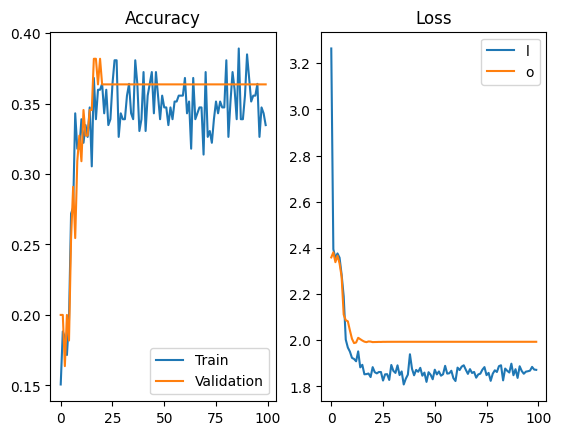

In [7]:
model = Classificator().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


since = time.time()
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print("-"*10)

    for phase in ["train", "validate"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0

        with tqdm(total=len(dataloaders[phase]), desc=f"{phase} phase") as pbar:
            for inputs, labels, in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_acc = (torch.sum(preds == labels.data).item() / inputs.size(0))
                pbar.set_postfix({"Loss": running_loss, "Accuracy": f"{batch_acc:.2f}%"})
                pbar.update(1)

        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        if phase == "train":
            train_acc.append(float(epoch_acc))
            train_loss.append(float(epoch_loss))
        else:
            val_acc.append(float(epoch_acc))
            val_loss.append(float(epoch_loss))

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    print()
    time_elapsed = time.time() - since
    print(f"Epoch finished at {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

torch.save(model.state_dict(), "Brazilian.pth")


plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label="Train")
plt.plot(range(len(val_acc)), val_acc, label="Validation")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label="Train")
plt.plot(range(len(val_loss)), val_loss, label="Validation")
plt.legend("lower right")
plt.title("Loss")

plt.show()